# Visualization with t-SNE

The stochastic neighbour embedding provides a powerful, non-parametric method to visualize high-dimensional data using our low-dimensional eyes. In this notebook, we'll look at the projecting from 128 dimensions down to two with the aim of finding clusters of data relevant to our problem. See [here](https://lvdmaaten.github.io/tsne/) for more information on the t-SNE algorithm. In addition, we'll also contrast the difference between the raw embedding layer created by the VGGish model, `X_pre`, and that created by our downstream task of determining whether sounds came from our target track or not, `X_post`.

## Setup

In [1]:
import os
import json
import numpy as np
np.random.seed(2018)
import pandas as pd
from sklearn.manifold import TSNE
from keras.models import load_model, Model

Using TensorFlow backend.


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [4]:
DATA_DIR = os.path.join(os.path.expanduser('~'), 'find-tune', 'data')
data = np.load(os.path.join(DATA_DIR, 'embedding_data.npz'))
X_pre, y, c, s, ids = data['X'], data['y'], data['c'], data['s'], data['i']
c = ['Target' if cat == 'target' else cat for cat in c]

## Model fitting and visualization

In [5]:
tsne = TSNE(n_components=2, random_state=2018)
X_pre_2D = tsne.fit_transform(X_pre)
print(X_pre_2D.shape)

(3452, 2)


In [6]:
def plot_factory(X, categories=5):
    """
    Plots a visualization of the low-dimensional t-SNE dataset, with a small number of categories highlighted. 
    The arg `categories` can be an int (then random categories plus target are chosen) or a list of user-
    specified categories of interest (target automatically added on). 
    Consider using fairly low values / short lists in order to keep the plot reasonable and interpretable.
    
    Arguments:
        X          = np.ndarray, of shape ? x 2, the low-dimensionsal representation
        categories = int, positive, the number of randomly-chosen categories (minus 1) 
                  OR list, of str, stating the names of the categories to be plotted
    
    Returns: DataFrame of dimension values and category labels.
    """
    
    if type(categories) is int: 
        n = categories
        assert n > 0
        non_target_cats = list(set(c).difference(set(['Target'])))
        non_target_cats = list(np.random.choice(non_target_cats, size=n-1)) if n > 1 else []
        plot_categories = ['Target'] + non_target_cats
    elif type(categories) is list:
        assert len(categories) > 0
        assert type(categories[0]) is str
        plot_categories = ['Target'] + categories if 'Target' not in categories else categories
    else:
        raise NotImplementedError()
        
    plot_labs = [cat if cat in plot_categories else 'Other' for cat in c]

    n_cols = len(plot_categories) + 1 # Extra one for the remainder not in plot_categories
    sns.set_palette(sns.color_palette("hls", n_colors=n_cols+1))

    # Create a DataFrame for plotting the dimensionality-reduced data
    df_tsne = pd.DataFrame(X, columns = ['dim1', 'dim2'])
    df_tsne['Category'] = plot_labs
    # Scatter
    sns.scatterplot(x='dim1', y='dim2', data=df_tsne,
                    hue='Category', hue_order=plot_categories + ['Other'],
                    alpha=0.75)
        
    return df_tsne

Although this is a lower dimensional map of the data, the cluster representations should respect those of the higher-dimensional space (at least approximately). It turns out that the snippets from our target track cluster together, which is a useful property if we want to be able to classify it. There are some other genuine clusters from the categories we have sampled, including hubbub, rapping and, potentially, wolf-whistling. 

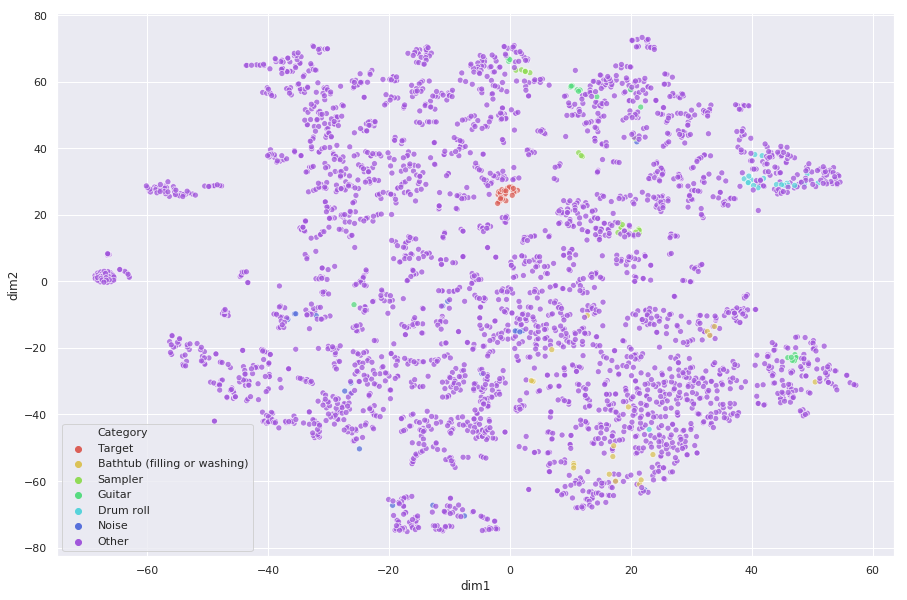

In [7]:
_ = plot_factory(X_pre_2D, 6)

From the categories highlighted in the next plot, it looks like it may be difficult to differentiate between the target tune and glockenspiels or doorbells - a potential source of false positives. 

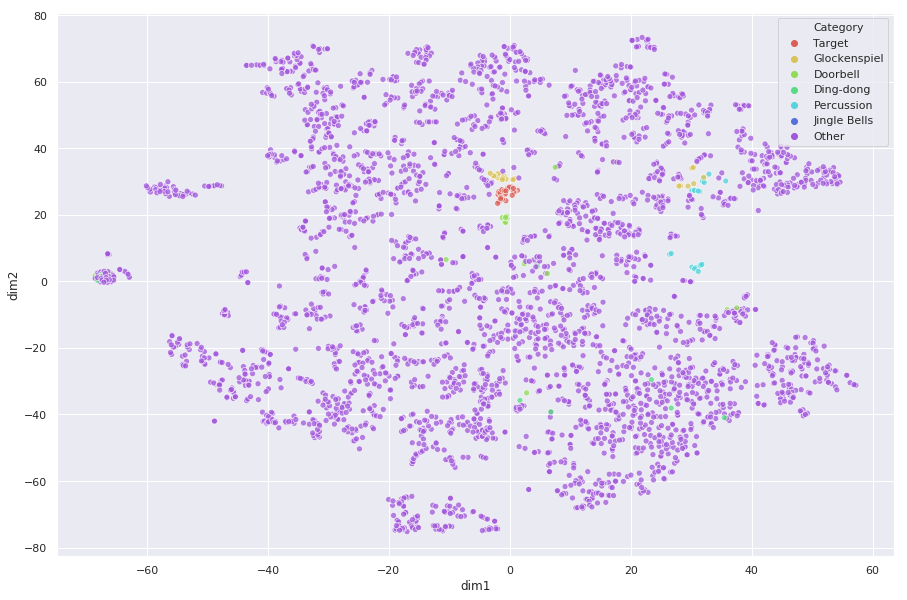

In [8]:
_ = plot_factory(X_pre_2D, ['Glockenspiel', 'Doorbell', 'Ding-dong', 'Percussion', 'Jingle Bells'])

## Trained embedding

What happens to the distribution of these sound clips after we have trained it on the classification task? Note: this uses a model that was trained using [this script](https://github.com/lukerm/find-tune/blob/master/models_with_embedding.py) for the purposes of classifying our particular tune. 

In [9]:
# Load the model trained on our bespoke data
# Assumes you have this intermediate model stored, which takes X as input
model = load_model(os.path.join(DATA_DIR, 'fold0', 'nn_fold0.model'))
embed_in = model.get_layer('vggish_feat_input').input
embed_out= model.get_layer('fc_last').output
post_embedding = Model(inputs=embed_in, outputs=embed_out)

In [10]:
post_embedding.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggish_feat_input (InputLaye (None, 128)               0         
_________________________________________________________________
fc_last (Dense)              (None, 128)               16512     
Total params: 16,512
Trainable params: 16,512
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Extract the embedding features of our trained classifier
X_post = post_embedding.predict(X_pre)
# Perform the t-SNE on this dataset
tsne_post = TSNE(n_components=2, random_state=2018)
X_post_2D = tsne.fit_transform(X_post)
print(X_post_2D.shape)

(3452, 2)


As can be seen from the scatter plot below, the neural network has created an embedding such that the target category - the song we want to identify - is very far from any other category. This is a visualization in the low-dimensional space, but we expect a similar phenomenon to occur in the high-dimensional one, too.

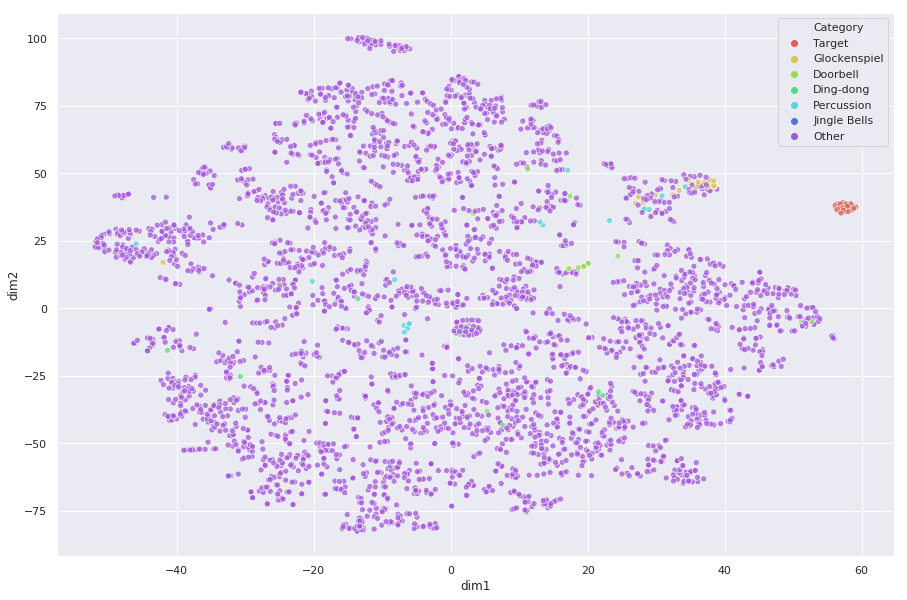

In [12]:
_ = plot_factory(X_post_2D, ['Glockenspiel', 'Doorbell', 'Ding-dong', 'Percussion', 'Jingle Bells'])